In [1]:
from pathlib import Path

from lunarsky import Time
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import lusee_faraday as ld

%matplotlib widget

In [2]:
NSIDE = 128
DATA_DIR = Path("/home/christian/Documents/research/lusee/lusee_faraday/data/")

fzoom = ld.utils.freqs_zoom()
print((fzoom[1]-fzoom[0])*1e6)
nfreqs = fzoom.size
print(nfreqs)

390.6250000014211
64


In [3]:
beam_file = DATA_DIR / "hfss_lbl_3m_75deg.2port.fits"
lusee_beam = ld.Beam.from_file(beam_file, frequency=30, nside=NSIDE)
lusee_beam.precompute_weights()

## Zenith Source

In [4]:
I, Q, U = ld.sky.point_src(nside=NSIDE, nfreqs=nfreqs)
pix = np.nonzero(I[0])[0]
print(pix)
RM = np.zeros_like(I[0])
RM[pix] = 100

[0]


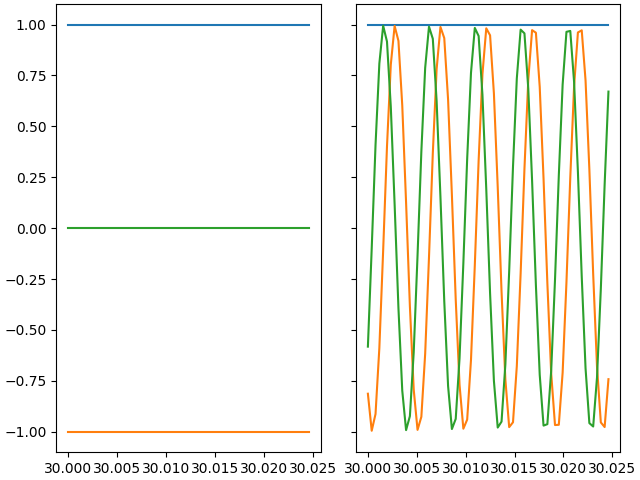

In [5]:
sky = ld.SkyModel(I, Q, U, RM, freq=fzoom, frame="topocentric")
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
axs[0].plot(fzoom, sky.I_map[:, 0])
axs[0].plot(fzoom, sky.Q_map[:, 0])
axs[0].plot(fzoom, sky.U_map[:, 0])
sky.apply_fd()
axs[1].plot(fzoom, sky.I_map[:, 0])
axs[1].plot(fzoom, sky.Q_map[:, 0])
axs[1].plot(fzoom, sky.U_map[:, 0])
plt.show()

In [7]:
cfg = ld.SimConfig(freqs=fzoom, times=np.array([0]), sky=sky, beam=lusee_beam, nside=NSIDE, faraday=True)
sim = ld.Simulator(cfg)
# point source so set mask
sim.grid.mask[1:] = False  # everything is effectively below horizon except zenith
vis = sim.simulate(in_topo=True)  # shape is ntimes, 3, nfreqs

Faraday rotation already applied.


In [8]:
pI, pQ, pU = sim.compute_stokes(vis)

/home/christian/Documents/research/lusee/lusee_faraday/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/christian/Documents/research/lusee/lusee_faraday/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


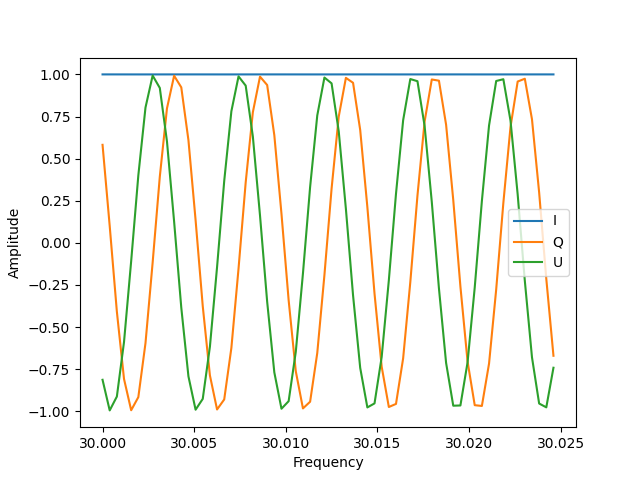

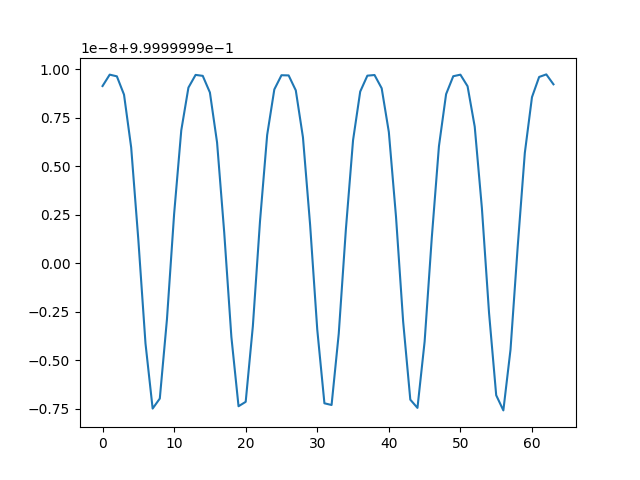

In [9]:
plt.figure()
plt.plot(fzoom, pI[0], label="I")
plt.plot(fzoom, pQ[0], label="Q")
plt.plot(fzoom, pU[0], label="U")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

plt.figure()
plt.plot(((pQ**2 + pU**2)/pI**2)[0], label="Pol fraction")
plt.show()

## Move source to alt=60, az=20

In [11]:
I, Q, U = ld.sky.point_src(lat_center=60, lon_center=20, nside=NSIDE, nfreqs=nfreqs)
pix = np.nonzero(I[0])[0]
print(pix)
RM = np.zeros_like(I[0])
RM[pix] = 100
sky = ld.SkyModel(I, Q, U, RM, freq=fzoom, frame="topocentric")

cfg = ld.SimConfig(freqs=fzoom, times=np.array([0]), sky=sky, beam=lusee_beam, nside=NSIDE, faraday=True)
sim = ld.Simulator(cfg)
# point source so set mask
sim.grid.mask.fill(False)
sim.grid.mask[pix] = True
vis = sim.simulate(in_topo=True)  # shape is ntimes, 3, nfreqs

[48384 48896 49407 49408 49409 49919]


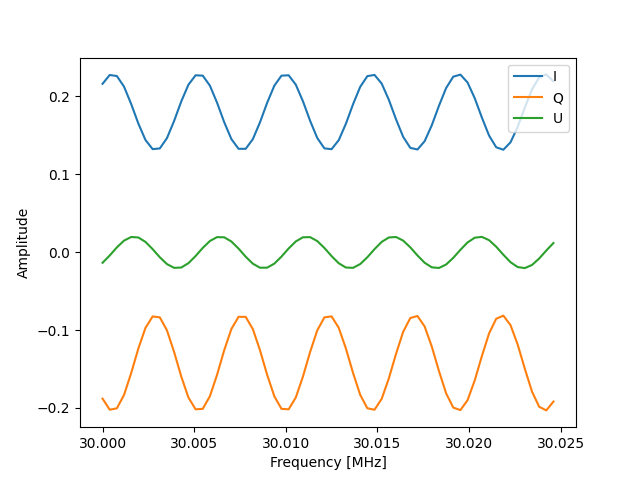

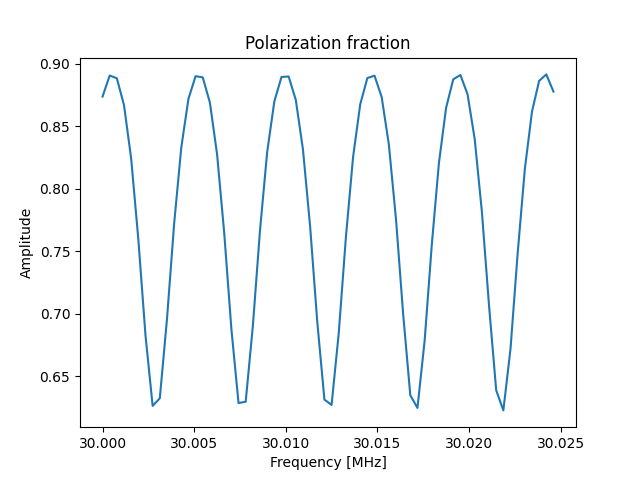

In [13]:
pI, pQ, pU = sim.compute_stokes(vis)
plt.figure()
plt.plot(fzoom, pI[0], label="I")
plt.plot(fzoom, pQ[0], label="Q")
plt.plot(fzoom, pU[0], label="U")
plt.legend(loc="upper right")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Amplitude")
plt.show()

plt.figure()
plt.plot(fzoom, np.sqrt((pQ**2 + pU**2)/pI**2)[0])
plt.title("Polarization fraction")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Amplitude")
plt.show()